# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import tree
from tqdm.notebook import trange

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Проверим данные на дубликаты.

In [5]:
df.duplicated().sum()

0

Проверим сбалансированность классов в таргете.

In [6]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Дубликаты и пропуски в данных отсутствуют. Сбаланмированность классов в таргете 70/30.

## Разбейте данные на выборки

Разделим данные на признаки - общие и целевые.

In [7]:
features, target = df.drop('is_ultra', axis=1), df['is_ultra']

Теперь выделим 3 выборки - обучающую, валидационную и тестовую в соотношении 3:1:1

In [8]:
features_train, features_test, target_train, target_test = (
    train_test_split(features, target,
                     test_size=0.4,
                     random_state=333,
                     stratify=target)
)

In [9]:
features_valid, features_test, target_valid, target_test = (
    train_test_split(features_test, target_test,
                     test_size=0.5,
                     random_state=333,
                     stratify=target_test)
)

In [10]:
pd.DataFrame({
    'data_all': [features.shape[0]],
    'data_train': [features_train.shape[0]],
    'data_valid': [features_valid.shape[0]],
    'data_test': [features_test.shape[0]]
})

,data_all,data_train,data_valid,data_test
0,3214,1928,643,643


Получили нужное разделение.

## Исследуйте модели

Рассмотрим и протестируем модель "решающего дерева". Переберем в алгоритме обучения разные варианты глубины дерева и минимальное количество семплов для разделения node - min_samples_split.

In [11]:
%%time
df_tree = pd.DataFrame()
tree_model = None
tree_result = 0
tree_depth = 1
tree_sample = 1
for depth in trange(1, 11):
    for sample in range(2, 11):
        model = DecisionTreeClassifier(random_state=333, max_depth=depth, min_samples_split=sample)
        model.fit(features_train, target_train)
        train_result = round(model.score(features_train, target_train), 3)
        valid_result = round(model.score(features_valid, target_valid), 3)
        df_tree = df_tree.append({'depth': depth, 'sample': sample, 'acc': train_result, 'type': 'train'}, ignore_index=True)
        df_tree = df_tree.append({'depth': depth, 'sample': sample, 'acc': valid_result, 'type': 'valid'}, ignore_index=True)
        if valid_result > tree_result:
            tree_model = model
            tree_result = valid_result
            tree_depth = depth
            tree_sample = sample
print(f'\nbest depth = {tree_depth}, sample = {tree_sample}, acc = {tree_result}')

  0%|          | 0/10 [00:00<?, ?it/s]


best depth = 6, sample = 2, acc = 0.79
CPU times: user 1.3 s, sys: 0 ns, total: 1.3 s
Wall time: 2.68 s


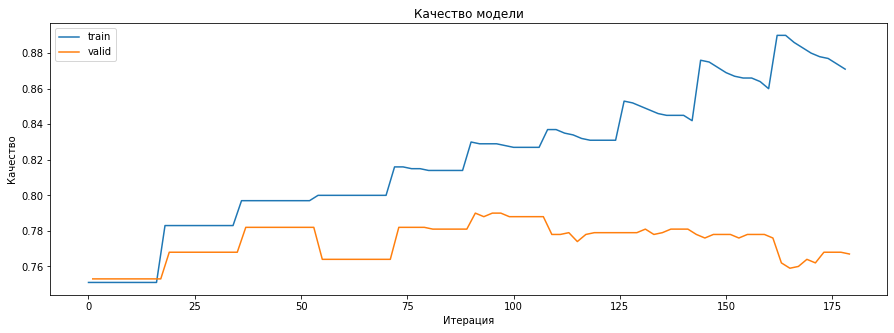

In [12]:
plt.figure(figsize = (15,5))
df_tree.query('type == "train"')['acc'].plot(label='train')
df_tree.query('type == "valid"')['acc'].plot(label='valid')
plt.title('Качество модели')
plt.xlabel('Итерация')
plt.ylabel('Качество')
plt.legend()
plt.show()

Построим heatmaps в зависимости от значений гипермараметров.

In [13]:
tree_train = df_tree.query('type == "train"').drop('type', axis=1)
tree_valid = df_tree.query('type == "valid"').drop('type', axis=1)

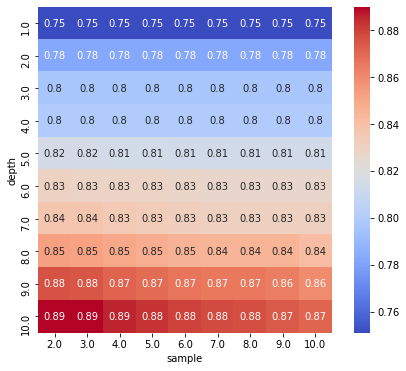

In [14]:
plt.figure(figsize=(8, 6)) 
_ = sns.heatmap(tree_train.pivot('depth', 'sample', values='acc'), annot=True, square=True, cmap='coolwarm')

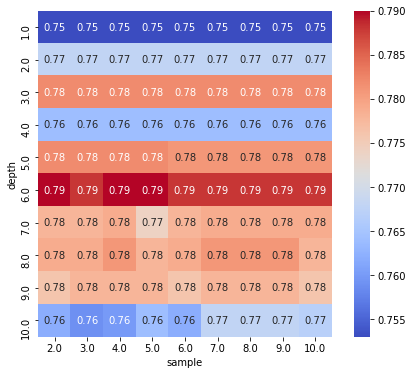

In [15]:
plt.figure(figsize=(8, 6)) 
_ = sns.heatmap(tree_valid.pivot('depth', 'sample', values='acc'), annot=True, square=True, cmap='coolwarm')

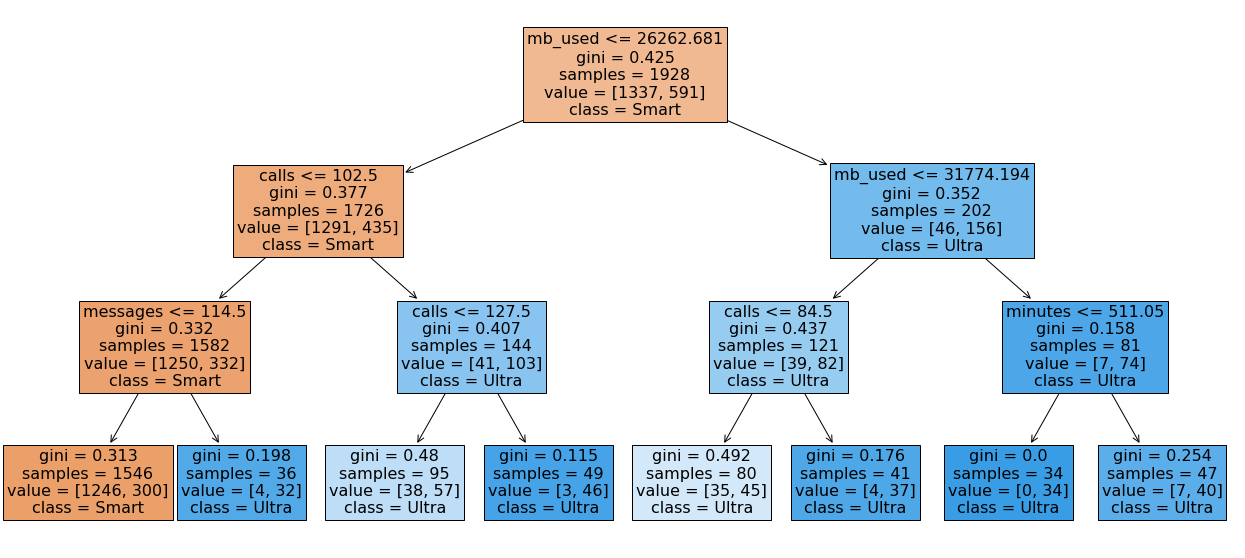

In [16]:
clf = DecisionTreeClassifier(max_depth=3, random_state=333)
clf.fit(features_train, target_train)
plt.figure(figsize=(22,10))
_ = tree.plot_tree(clf,
                   feature_names=features.columns.values, 
                   class_names=['Smart','Ultra'],
                   filled=True,
                   fontsize = 16)

Получили довольно не плохое качество, как видно с увеличением глубины и min_samples_split качество не растет, а потом даже начинает падать. Получаем переобучение.

Далее рассмотрим модель "случайный лес", предположительно у нее должно получиться более высокое качество. Переберем в алгоритме обучения разные варианты гиперпараметров.

In [17]:
big_train = pd.concat([features_train, features_valid])
big_target = pd.concat([target_train, target_valid])

In [18]:
big_train.shape, big_target.shape

((2571, 4), (2571,))

In [19]:
%%time
clf = RandomForestClassifier()
parametrs = {'n_estimators': range(80, 121, 10),
             'max_depth': range(1,13, 2),
             'min_samples_leaf': range(1,8),
             'min_samples_split': range(2,10,2)}
grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(big_train, big_target)
forest_model = grid.best_estimator_

CPU times: user 19min 41s, sys: 6.56 s, total: 19min 47s
Wall time: 31min 58s


In [20]:
grid.best_params_

{'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 110}

In [21]:
grid.best_score_

0.8125231385289562

Получили еще более лучший результат.

Протестируем третью модель - "логистическая регрессия". Менять в гиперпараметрах тут особо нечего...

In [22]:
log_model = LogisticRegression(random_state=333, solver='lbfgs', max_iter=1000)
log_model.fit(features_train, target_train)
result = round(log_model.score(features_valid, target_valid), 3)
print(f'acc = {result}')

acc = 0.706


Качество низкое, но зато скорость обучения самая быстрая.

### Краткий вывод

Модель дерева дала неплохой результат - 0.79 и среднюю скорость обучения. Модель случайного леса, как и предполагалось дала еще выше качество - 0.816, но время обучения больше. Третья модель - логистическая регрессия имеет самую низкое время обучения, но и качество оказалось самым низким.

## Проверьте модель на тестовой выборке

Проверим качество моделей на тестовой выборке.

Попробуем обучить модель на большей выборке - объединенные train и valid данные.

In [23]:
forest_model.fit(features_train, target_train)
print('Качество на выборке train:', forest_model.score(features_test, target_test))

forest_model.fit(big_train, big_target)
print('Качество на выборке train + valid:', forest_model.score(features_test, target_test))

Качество на выборке train: 0.80248833592535
Качество на выборке train + valid: 0.8149300155520995


Качество модели на тестовой выборке вышло почти таким же, как на валидационной. Хороший показатель.

## (бонус) Проверьте модели на адекватность

Чтобы проверить модели на адекватность сравним их с простейшей (dummy) моделью, которая всегда предсказывает наиболее часто встречающийся класс `(параметр - strategy="most_frequent")`, так мы сможем оценить их адекватность.

In [24]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=333)
dummy_clf.fit(features_train, target_train)
round(dummy_clf.score(features_test, target_test), 3)

0.694

У всех моделей качество на валидационной выборке выше простейшей модели, что указывает на адекватность наших моделей.

## Чек-лист готовности проекта

Изучили и проверили данные. Дубликаты и пропуски в данных отсутствуют. Сбалансированность классов в таргете 70/30.<br>

Разделили данные на признаки - общие и целевые. Выделили 3 выборки - обучающую, валидационную и тестовую в соотношении 3:1:1.<br>

Рассмотрели и протестировали модели "решающего дерева" и "случайный лес" с перебором в алгоритме обучения разных гиперпараметров. Так же протестировали третью модель - "логистическая регрессия".<br>

Модель дерева дала неплохой результат - 0.79 и среднюю скорость обучения. Модель случайного леса, как и предполагалось дала еще выше качество - 0.811, но время обучения больше. Третья модель - логистическая регрессия имеет самое быстрое время обучения, но и качество оказалось самым низким.<br>

Для финального теста выбрали модель "случайный лес". Качество модели на тестовой выборке вышло чуть выше - 0.826. Хороший показатель.<br>

Проверили модели на адекватность. У всех моделей качество на валидационной выборке выше простейшей модели, что указывает на адекватность наших моделей.